In [1]:
import pickle
import shutil
from pathlib import Path

import disklab
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Javascript
from gofish import imagecube
from matplotlib.colors import Normalize

from helper_functions import make_disklab2d_model, read_opacs, write_radmc3d
from log_prob import log_prob

import astropy.constants as c
from astropy.io import fits

radmc3d_exec = Path('~/bin/radmc3d').expanduser()
au = c.au.cgs.value

In [2]:
fname = "options.pickle"
with open(fname, "rb") as fb:
    options = pickle.load(fb)

ndim = 7

# original
p0 = [7.0, 0.730, 0.558, 0.017, 0.625, 0.008, 0.050]

# error radmc continuum
# path = Path("/Users/franceschi/mysims/IMLup/IMLup_SPHERE_fit/old_runs/run_error_radmc_continuum_854728122")
# error radmc scattering
# path = Path("/Users/franceschi/mysims/IMLup/IMLup_SPHERE_fit/old_runs/run_error_radmc_scattering_982086481")
# error write radmc

# p0 = [8.84825702,  1.95662302, -0.31526693,  2.10656677, 0.52873744, 0.02382286, -1.10552185]


In [3]:
options['beam_sca']

(0.04, 0.04, 0.0)

In [4]:
prob, blob = log_prob(p0, options, debugging=True)
print(prob)
Javascript("new Notification('Cell Execution Has Finished')")

/Users/franceschi/mysims/IMLup/IMLup_SPHERE_fit/helper_functions.py:63: UserWarning: Disk mass is unreasonably high: M_disk / Mstar = 0.3
  warnings.warn(f'Disk mass is unreasonably high: M_disk / Mstar = {d.mass/mstar:.2g}')


disk to star mass ratio = 0.3
Reading runs/run_3806592744/image.out
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Reading runs/run_3806592744/image_sca.out
stokes parameter: Q
fname:  runs/run_3806592744/image_Q.fits
Reading runs/run_3806592744/image_sca.out
stokes parameter: U
fname:  runs/run_3806592744/image_U.fits
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
-19.38941445079962


<IPython.core.display.Javascript object>

# Debugging

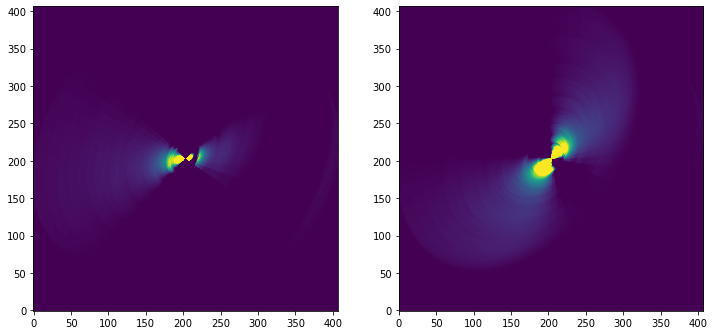

In [13]:
# folder = Path('runs') / f'run_{blob}'
folder  = Path('/Users/franceschi/mysims/IMLup/IMLup_SPHERE_fit/runs/run_198762978')

with fits.open(folder / 'image_Q.fits') as hdul:
    data_Q = hdul[0].data[0]
with fits.open(folder / 'image_U.fits') as hdul:
    data_U = hdul[0].data[0]


f, ax = plt.subplots(1, 2, figsize=[12, 10])
norm = Normalize(1e-11, 7e-7)
ax[0].imshow(data_Q, norm=norm, origin='lower')
ax[1].imshow(data_U, norm=norm, origin='lower')

In [14]:
from helper_functions import get_normalized_profiles

fname_qphi_sim = folder / 'image_Qphi.fits'

with open('options.pickle', 'rb') as fff:
    options = pickle.load(fff)

profiles_sca_sim = get_normalized_profiles(
        str(fname_qphi_sim),
        clip=options['clip'],
        inc=options['inc'],
        PA=options['PA'],
        z0=options['z0'],
        psi=options['psi'],
        beam=options['beam_sca'])

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [25]:
profiles_sca_sim['B'].keys()

dict_keys(['x', 'y', 'dy', 'mask', 'norm'])

In [6]:
temp_path = Path(f'/Users/franceschi/mysims/IMLup/IMLup_SPHERE_fit/runs/run_')

radmc_call_mm = f"image incl {options['inc']} posang {options['PA'] - 90} npix 500 lambda {options['lam_mm'] * 1e4} sizeau {2 * options['rout'] / au} secondorder  setthreads 1"
disklab.radmc3d.radmc3d(
    radmc_call_mm,
    path=temp_path,
    executable=str(radmc3d_exec)
)

FileNotFoundError: [Errno 2] No such file or directory: PosixPath('/Users/franceschi/mysims/IMLup/IMLup_SPHERE_fit/runs/run_'): PosixPath('/Users/franceschi/mysims/IMLup/IMLup_SPHERE_fit/runs/run_')

In [ ]:
temp_path = Path(f'/Users/franceschi/mysims/IMLup/IMLup_SPHERE_fit/runs/run_852090488')

iq_sca_obs = imagecube(str(options['fname_sca_obs']), FOV=options['clip'])

sizeau = np.diff(iq_sca_obs.xaxis[[-1, 0]])[0] * options['distance'] * iq_sca_obs.nxpix / (iq_sca_obs.nxpix - 1) * 1.0000000000000286
radmc_call_sca = f"image incl {options['inc']} posang {options['PA'] - 90} npix {iq_sca_obs.data.shape[0]} lambda {options['lam_sca'] * 1e4} sizeau {sizeau} setthreads 4"
disklab.radmc3d.radmc3d(
    radmc_call_sca,
    path=temp_path,
    executable=str(radmc3d_exec))

In [ ]:
RMS_jyb = options['RMS_jyb']

read the debugging dict

In [ ]:
with open(temp_path.with_suffix('.pickle'), 'rb') as fh:
    info = pickle.load(fh)

info

In [ ]:
iq_mm_obs = info['iq_mm_obs']
iq_sca_obs = info['iq_sca_obs']
iq_mm_sim = info['iq_mm_sim']
iq_sca_sim = info['iq_sca_sim']

In [ ]:
iq_mm_obs.data.shape

In [ ]:
iq_mm_sim.data.shape

**Plot mm - images**

In [ ]:
im_cgs_sim = iq_mm_sim.data * iq_mm_sim.pix_per_beam / iq_mm_sim.beamarea_str * 1e-23
im_cgs_obs = iq_mm_obs.data / iq_mm_sim.beamarea_str * 1e-23

f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
vmin = RMS_jyb * 1e-23 / iq_mm_obs.beamarea_str # the RMS from dsharp (Jy/beam) to CGS conversion
vmax = 20 * vmin
ax[0].imshow(im_cgs_sim, extent=iq_mm_sim.extent, vmin=vmin, vmax=vmax, origin='lower')
ax[1].imshow(im_cgs_obs, extent=iq_mm_obs.extent, vmin=vmin, vmax=vmax, origin='lower')
ax[0].set_xlim([2, -2])
ax[0].set_ylim([-2, 2]);

ax[0].axis('off')
ax[1].axis('off')
f.subplots_adjust(wspace=0)
# f.savefig('mm.pdf', transparent=True, bbox_inches='tight')

**Plot IR - images**

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
vmax = np.median(iq_sca_sim.data)*2e1
ax[0].imshow(iq_sca_sim.data, extent=iq_sca_sim.extent, vmin=vmax/1e2, vmax=vmax, origin='lower')
vmax = np.median(iq_sca_obs.data)*2e1
ax[1].imshow(iq_sca_obs.data, extent=iq_sca_obs.extent, vmin=vmax/1e2, vmax=vmax, origin='lower')
ax[0].set_xlim([2, -2])
ax[0].set_ylim([-2, 2])

ax[0].axis('off')
ax[1].axis('off')
f.subplots_adjust(wspace=0)
# f.savefig('sca.pdf', transparent=True, bbox_inches='tight')

**Plot the profiles**

In [ ]:
x_mm_sim = info['x_mm_sim']
y_mm_sim = info['y_mm_sim']
dy_mm_sim = info['dy_mm_sim']

profiles = info['profiles_sca_sim']
profiles_obs = info['profiles_sca_obs']

In [ ]:
disk_surface = dict(inc=options['inc'], PA=options['PA'], z0=options['z0'], psi=options['psi'])

In [ ]:
norm = profiles['B']['norm']

data = iq_sca_sim.data.copy()
if iq_sca_sim.bunit.lower() == 'jy/beam':
    data *= 1e-23 / iq_sca_sim.beamarea_str
elif iq_sca_sim.bunit.lower() == 'jy/pixel':
    data *= 1e-23 * iq_sca_sim.pix_per_beam / iq_sca_sim.beamarea_str

f, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
ax[0].imshow(data / norm, extent=iq_sca_sim.extent, vmin=0.1, vmax=5, origin='lower')

# simulated (+masks)

for i, key in enumerate(profiles.keys()):
    profile = profiles[key]
    x = profile['x']
    y = profile['y']
    dy = profile['dy']
    mask = profile['mask']

    iq_sca_sim.plot_mask(ax=ax[0], **disk_surface, **mask, mask_alpha=0, mask_color=f'C{i}')
    
    ax[1].semilogy(x, y, c=f'C{i}')
    ax[1].fill_between(x, y - dy, y + dy, fc=f'C{i}', alpha=0.5)
    
# observed
    
norm = profiles_obs['B']['norm']
for i, key in enumerate(profiles_obs.keys()):
    profile = profiles_obs[key]
    x = profile['x']
    y = profile['y']
    dy = profile['dy']
    mask = profile['mask']

    ax[1].semilogy(x, y, f'C{i}--')
    ax[1].fill_between(x, y - dy, y + dy, fc=f'C{i}', alpha=0.5)
    

ax[0].set_xlim([2, -2])
ax[0].set_ylim([-2, 2]);

In [ ]:
if not ((0 < info['params']['sigma_coeff'] < 1e4) and
    (-5 < info['params']['sigma_exp'] < 5) and
    (-5 < info['params']['size_exp'] < 5) and
    (1e-4 < info['params']['amax_coeff'] < 100) and
    (-5 < info['params']['amax_exp'] < 5) and
    (1e-6 < info['params']['d2g_coeff'] < 1e2) and
    (-5 < info['params']['d2g_exp'] < 5)):
    print("Parameters out of prior")


disk2d = make_disklab2d_model(
    p0,
    options['mstar'],
    options['lstar'],
    options['tstar'],
    options['nr'],
    options['alpha'],
    options['rin'],
    options['rout'],
    options['r_c'],
    options['fname_opac'],
    show_plots=False
)

opac_dict = read_opacs(options['fname_opac'])
lam_opac = opac_dict['lam']
n_a = len(opac_dict['a'])

temp_path = Path('test/')
if temp_path.is_dir():
    shutil.rmtree(temp_path)
temp_path.mkdir()

write_radmc3d(disk2d, lam_opac, temp_path, show_plots=False)

fname_mm_sim = temp_path / 'image_mm.fits'

radmc_call_mm = f"image incl {options['inc']} posang {options['PA'] - 90} npix 500 lambda {options['lam_mm'] * 1e4} sizeau {2 * options['rout'] / au} secondorder  setthreads 1"
disklab.radmc3d.radmc3d(
    radmc_call_mm,
    path=temp_path,
    executable=str(radmc3d_exec)
)